In [19]:
"""
Demo script comparing Event-Based vs Frame-Based tracking
Generates synthetic moving object scenario and compares both approaches
"""
import numpy as np
import cv2
import matplotlib.pyplot as plt
from event_simulator import EventSimulator
from event_tracker import EventBasedTracker
from frame_tracker import FrameBasedTracker

In [20]:
class SyntheticSceneGenerator:
        """Generate synthetic scenes with moving objects"""
        
        def __init__(self, width: int = 640, height: int = 480):
            self.width = width
            self.height = height
            self.objects = []
            
        def add_moving_object(self, start_pos, velocity, radius=20):
            """Add a moving circular object"""
            self.objects.append({
                'pos': np.array(start_pos, dtype=float),
                'vel': np.array(velocity, dtype=float),
                'radius': radius
            })
        
        def generate_frame(self, t: float) -> np.ndarray:
            """
            Generate frame at time t
            
            Args:       
                t: Time in seconds
                
            Returns:
                Grayscale frame
            """
            frame = np.ones((self.height, self.width), dtype=np.uint8) * 30
            
            for obj in self.objects:
                # Update position
                pos = obj['pos'] + obj['vel'] * t
                
                # Wrap around boundaries
                pos[0] = pos[0] % self.width
                pos[1] = pos[1] % self.height
                
                # Draw circle
                cv2.circle(frame, 
                        (int(pos[0]), int(pos[1])), 
                        obj['radius'], 
                        200, 
                        -1)
            
            # Add some noise
            noise = np.random.normal(0, 5, frame.shape).astype(np.int16)
            frame = np.clip(frame.astype(np.int16) + noise, 0, 255).astype(np.uint8)
            
            return frame

   

In [21]:
def run_comparison_demo():
        """Run complete comparison demo"""
        
        print("=" * 60)
        print("Event-Based vs Frame-Based Object Tracking Comparison")
        print("=" * 60)
        
        # Setup scene
        scene = SyntheticSceneGenerator(640, 480)
        scene.add_moving_object(start_pos=[100, 240], velocity=[100, 40], radius=25)
        scene.add_moving_object(start_pos=[300, 140], velocity=[-60, 60], radius=35)
        scene.add_moving_object(start_pos=[500, 240], velocity=[-100, 40], radius=25)
        
        # Initialize trackers
        event_sim = EventSimulator(contrast_threshold=0.15)
        event_tracker = EventBasedTracker(spatial_window=30, temporal_window=50000)
        frame_tracker = FrameBasedTracker(frame_rate=30.0)
        
        # Simulation parameters
        duration = 5.0  # seconds
        dt = 1.0 / 30.0
        num_frames = int(duration / dt)
        
        print(f"\nRunning simulation for {duration}s ({num_frames} frames)...")
        
        # Storage for results
        event_metrics_history = []
        frame_metrics_history = []
        event_counts = []

        cv2.namedWindow("Synthetic Scene", cv2.WINDOW_NORMAL)

        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        out = cv2.VideoWriter(
            "synthetic_moving_circles.mp4",
            fourcc,
            5,
            (640, 480),
            isColor=False
        )
        
        try: 
            # Run simulation
            for i in range(num_frames):
                t = i * dt
                
                # Generate frame
                frame = scene.generate_frame(t)
            
                # Event-based tracking
                events = event_sim.frame_to_events(frame, timestamp=t * 1e6)
                event_objects = event_tracker.update(events)
                event_counts.append(len(events))
            
                # Frame-based tracking (respects frame rate)
                frame_objects = frame_tracker.update(frame, timestamp=t)

                # Draw tracking results on frame
                for obj in frame_objects:
                    x, y, w, h = obj["bbox"]
                    cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
                cv2.imshow("Synthetic Scene", frame)
                if cv2.waitKey(int(1000 * dt)) & 0xFF == 27:
                    break
                out.write(frame)

                # Progress indicator
                if (i + 1) % 60 == 0:
                    print(f"  Processed {i+1}/{num_frames} frames...")

            out.release()

        except KeyboardInterrupt:
            print("\nSimulation interrupted by user.")
        finally:
            cv2.destroyAllWindows()
        
        # Get final metrics
        event_metrics = event_tracker.get_metrics()
        frame_metrics = frame_tracker.get_metrics()
        
        # Print comparison
        print("\n" + "=" * 60)
        print("RESULTS COMPARISON")
        print("=" * 60)
        
        print("\nEvent-Based Tracker:")
        print(f"  Average Latency: {event_metrics['avg_latency_us']:.2f} μs")
        print(f"  Maximum Latency: {event_metrics['max_latency_us']:.2f} μs")
        print(f"  Total Events Processed: {event_metrics['total_events']}")
        print(f"  Events per Update: {event_metrics['events_per_update']:.1f}")
        print(f"  Avg Events per Frame: {np.mean(event_counts):.1f}")
        
        print("\nFrame-Based Tracker:")
        print(f"  Average Latency: {frame_metrics['avg_latency_ms']:.2f} ms")
        print(f"  Maximum Latency: {frame_metrics['max_latency_ms']:.2f} ms")
        print(f"  Total Frames Processed: {frame_metrics['total_frames']}")
        print(f"  Effective FPS: {frame_metrics['effective_fps']:.1f}")
        print(f"  Target FPS: {frame_metrics['target_fps']:.1f}")
        
        # Latency comparison
        latency_ratio = (frame_metrics['avg_latency_ms'] * 1000) / event_metrics['avg_latency_us']
        print(f"\n📊 Frame-based is {latency_ratio:.1f}x slower than event-based")
        
        # Data efficiency
        total_pixels = num_frames * 640 * 480
        total_events = event_metrics['total_events']
        compression_ratio = total_pixels / total_events
        print(f"📊 Event representation is {compression_ratio:.1f}x more efficient")
        
        # Power estimation (simplified model)
        # Frame-based: process all pixels every frame
        # Event-based: process only changed pixels
        frame_power = num_frames * 640 * 480  # arbitrary units
        event_power = total_events
        power_saving = ((frame_power - event_power) / frame_power) * 100
        print(f"📊 Estimated power saving: {power_saving:.1f}%")
        
        print("\n" + "=" * 60)
        print("KEY INSIGHTS")
        print("=" * 60)
        print("✓ Event-based: Asynchronous, low-latency, sparse representation")
        print("✓ Frame-based: Synchronous, complete spatial info, higher latency")
        print("✓ Event-based excels in: fast motion, power efficiency, temporal resolution")
        print("✓ Frame-based excels in: dense reconstruction, mature algorithms")
        
        return event_metrics, frame_metrics, event_counts


In [22]:
def visualize_comparison(event_metrics, frame_metrics, event_counts):
        """Create comparison visualizations"""
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle('Event-Based vs Frame-Based Tracking Comparison', fontsize=14, fontweight='bold')
        
        # Latency comparison
        ax1 = axes[0, 0]
        trackers = ['Event-Based', 'Frame-Based']
        latencies = [
            event_metrics['avg_latency_us'] / 1000,  # Convert to ms
            frame_metrics['avg_latency_ms']
        ]
        colors = ['#2ecc71', '#e74c3c']
        ax1.bar(trackers, latencies, color=colors, alpha=0.7)
        ax1.set_ylabel('Latency (ms)', fontweight='bold')
        ax1.set_title('Average Processing Latency')
        ax1.grid(axis='y', alpha=0.3)
        
        # Event rate over time
        ax2 = axes[0, 1]
        ax2.plot(event_counts, color='#3498db', linewidth=1)
        ax2.set_xlabel('Frame Number', fontweight='bold')
        ax2.set_ylabel('Events Generated', fontweight='bold')
        ax2.set_title('Event Generation Rate')
        ax2.grid(alpha=0.3)
        
        # Data volume comparison
        ax3 = axes[1, 0]
        data_types = ['Frame-Based\n(Full Frames)', 'Event-Based\n(Sparse Events)']
        data_volumes = [
            frame_metrics['total_frames'] * 640 * 480,  # Total pixels
            event_metrics['total_events']  # Total events
        ]
        ax3.bar(data_types, np.array(data_volumes) / 1e6, color=colors, alpha=0.7)
        ax3.set_ylabel('Data Volume (Million pixels/events)', fontweight='bold')
        ax3.set_title('Total Data Processed')
        ax3.grid(axis='y', alpha=0.3)
        
        # Summary metrics
        ax4 = axes[1, 1]
        ax4.axis('off')
        
        summary_text = f"""
        PERFORMANCE SUMMARY
        
        Event-Based Tracker:
        • Latency: {event_metrics['avg_latency_us']:.1f} μs
        • Events: {event_metrics['total_events']:,}
        • Asynchronous processing
        
        Frame-Based Tracker:
        • Latency: {frame_metrics['avg_latency_ms']:.1f} ms
        • Frames: {frame_metrics['total_frames']}
        • Synchronous @ {frame_metrics['target_fps']:.0f} FPS
        
        Speed Advantage: {(frame_metrics['avg_latency_ms']*1000/event_metrics['avg_latency_us']):.1f}x faster
        Data Efficiency: {(frame_metrics['total_frames']*640*480/event_metrics['total_events']):.1f}x less data
        """
        
        ax4.text(0.1, 0.5, summary_text, fontsize=10, 
                verticalalignment='center', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
        
        plt.tight_layout()
        plt.savefig('tracking_comparison.png', dpi=150, bbox_inches='tight')
        print("\n✓ Visualization saved as 'tracking_comparison.png'")
        plt.show()


In [23]:

# def generate_video():
#     width, height = 640, 480
#     fps = 30
#     duration = 5  # seconds
#     num_frames = fps * duration

#     # Create synthetic scene
#     scene = SyntheticSceneGenerator(width, height)
#     scene.add_moving_object(start_pos=[100, 240], velocity=[80, 40], radius=25)
#     scene.add_moving_object(start_pos=[500, 200], velocity=[-60, 30], radius=20)

#     # Video writer
#     fourcc = cv2.VideoWriter_fourcc(*"mp4v")
#     out = cv2.VideoWriter(
#         "synthetic_moving_circles.mp4",
#         fourcc,
#         fps,
#         (width, height),
#         isColor=False
#     )

#     # Generate frames
#     for i in range(num_frames):
#         t = i / fps  # time in seconds
#         frame = scene.generate_frame(t)

#         out.write(frame)

#     out.release()
#     print("✅ Video saved as synthetic_moving_circles.mp4")

# if __name__ == "__main__":
#     generate_video()


Event-Based vs Frame-Based Object Tracking Comparison

Running simulation for 5.0s (150 frames)...


  Processed 60/150 frames...
  Processed 120/150 frames...

RESULTS COMPARISON

Event-Based Tracker:
  Average Latency: 540845.46 μs
  Maximum Latency: 883458.57 μs
  Total Events Processed: 21449687
  Events per Update: 142997.9
  Avg Events per Frame: 142997.9

Frame-Based Tracker:
  Average Latency: 22.97 ms
  Maximum Latency: 144.96 ms
  Total Frames Processed: 150
  Effective FPS: 43.5
  Target FPS: 30.0

📊 Frame-based is 0.0x slower than event-based
📊 Event representation is 2.1x more efficient
📊 Estimated power saving: 53.5%

KEY INSIGHTS
✓ Event-based: Asynchronous, low-latency, sparse representation
✓ Frame-based: Synchronous, complete spatial info, higher latency
✓ Event-based excels in: fast motion, power efficiency, temporal resolution
✓ Frame-based excels in: dense reconstruction, mature algorithms

✓ Visualization saved as 'tracking_comparison.png'


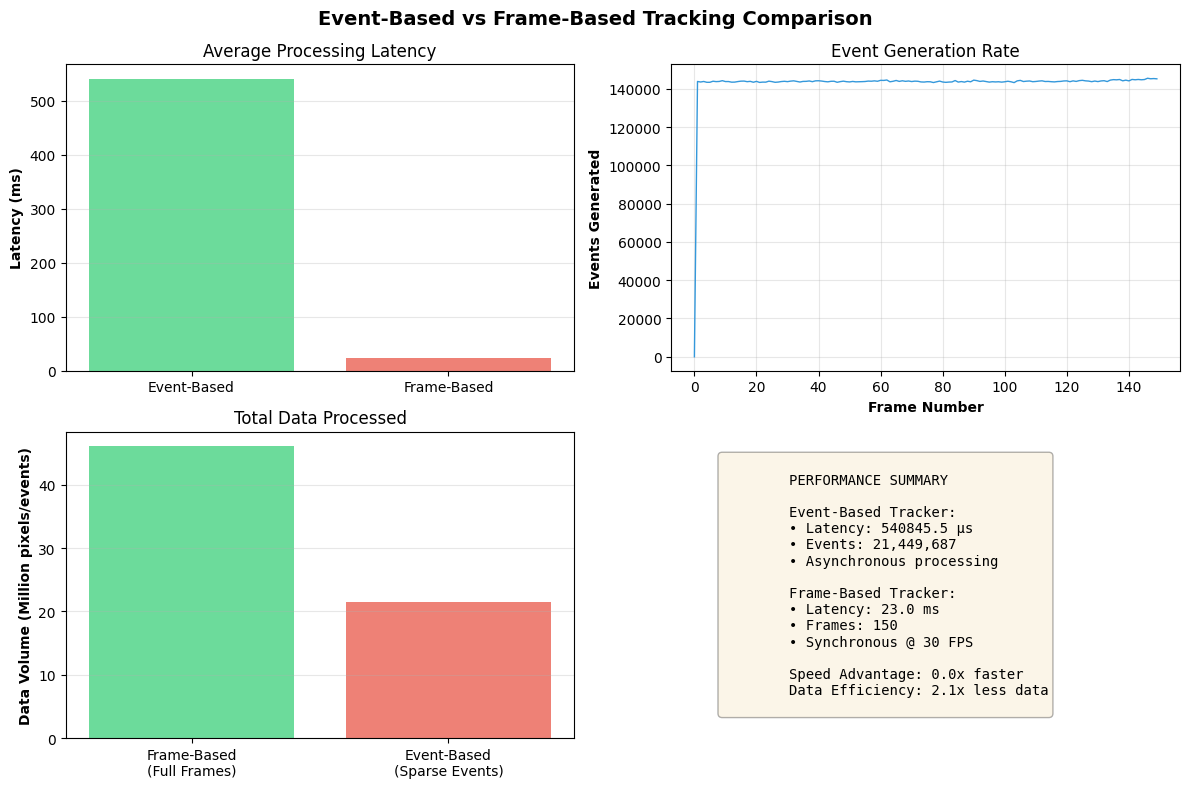


✓ Demo complete! Check the generated plots and metrics.


In [24]:
if __name__ == "__main__":
        # Run the comparison
        event_metrics, frame_metrics, event_counts = run_comparison_demo()
        
        # Generate visualizations
        visualize_comparison(event_metrics, frame_metrics, event_counts)
        
        print("\n✓ Demo complete! Check the generated plots and metrics.") 